# P5 - Vehicle Detection - Data exploration and Features Selection

# File sections:
* import section
* general utilities
* load the training data and data exporation
* HOG parameters selection by visualization
* Spacial parameters selection by visualization
* Color Hist parmeters selection

## imports for the whole project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from random import randint
import time
from sklearn.svm import LinearSVC

%matplotlib inline

### imports for the whole project - end

## General Utility Functions - not directed related to the project

In [2]:
# Read Image
def readImage(imageFileName):
    return (mpimg.imread(imageFileName))

def readImages(dir, pattern = '*[.png][.jpg][.jepg]', cFormat='RGB'):
    # read all images with the given patterns (extensions) in the sub-directories
    # Example of a pattern: pattern = '*[.png][.jpg]'

    """
    Returns an image list with the image contained on the directory `dir` matching the `pattern`.
    pattern
    """
    images = []
    for imageFileName in glob.iglob(dir + '**/' + pattern, recursive=True):
        images.append(readImage(imageFileName))
    return images

# Ready the images filenames only. Used when not all the images are needed to be loaded.
def readImagesFileNames(dir, pattern = '*[.png][.jpg][.jepg]', cFormat='RGB'):
    # read all images with the given patterns (extensions) in the sub-directories
    # Example of a pattern: pattern = '*[.png][.jpg]'

    """
    Returns 2 lists of image names list. File name and full path name

    """
    imagesFileNames = []
    imagesFullFileNames = []
    for imageFullFileName in glob.iglob(dir + '**/' + pattern, recursive=True):
        imagesFullFileNames.append(imageFullFileName)
        imagesFileNames.append(os.path.basename(imageFullFileName))
    return imagesFileNames, imagesFullFileNames

def display_save_images_single_line(images, folder, titles, figTitel='', figsize=(6, 3), gray=False):
    plt.figure(figsize=figsize)
    for i in range (len(images)):
        plt.subplot(1, len(titles), i+1)
        plt.title(titles[i])
#        plt.axis('off')
        if gray == True:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i]) # , cmap='binary'
        plt.tight_layout(pad=0.50)
    plt.tight_layout(pad=0.50)
#    plt.xlabel(figTitel) #, fontdict=font)
    plt.suptitle(figTitel, fontsize=16)
    plt.subplots_adjust(left=0, wspace=0, top=0.8)
    if not os.path.exists(folder): #if output dir doesn't exists, create it
        os.makedirs(folder)
    plt.savefig(os.path.join(folder, figTitel))
    print(folder, figTitel)
    plt.show(folder,figTitel )

def display_save_2_images(images, titles, display_flag='TRUE', image_file_full_name='./image.png', file_prefix="", file_suffix="", output_directory='./output_images/'):
    if (display_flag == 'TRUE'):
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.title(titles[0])
        plt.axis('off')
        plt.imshow(images[0], cmap='binary')
        plt.subplot(1, 2, 2)
        plt.title(titles[1])
        plt.axis('off')
        plt.imshow(images[1], cmap='binary')
        plt.tight_layout(pad=0.50)
        plt.tight_layout(pad=0.50)
        plt.suptitle(new_file_name)
        base=os.path.basename(image_file_full_name)
        (file_name,ext) = os.path.splitext(base)
        new_file_name = file_prefix + file_name + file_suffix + ext
        image_file_full_name_newdir = os.path.join(output_directory, new_file_name)
        print ('Saving: ' , image_file_full_name, new_file_name, image_file_full_name_newdir)
        if not os.path.exists(output_directory): #if output dir doesn't exists, create it
            os.makedirs(output_directory)
        plt.savefig(image_file_full_name_newdir)
        plt.show()
    return

### General Utility Functions - end

## Load the training data and data exporation

### Read the training images

In [3]:
vehiclesFN, vehiclesFFN = readImagesFileNames('./training_images/vehicles/vehicles/', '*.png')
non_vehiclesFN, non_vehiclesFFN = readImagesFileNames('./training_images/non-vehicles/non-vehicles/', '*.png')
print ('Number of Vehicle images = ' + str(len(vehiclesFN)))
print ('Number of non-Vehicle images = ' + str(len(non_vehiclesFFN)))

Number of Vehicle images = 8791
Number of non-Vehicle images = 8968


 ### Data exploration

./SampleImages/ Sample_0


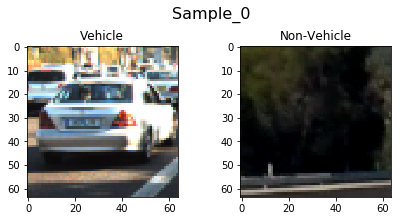

./SampleImages/ Sample_1


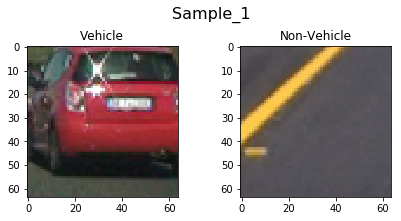

./SampleImages/ Sample_2


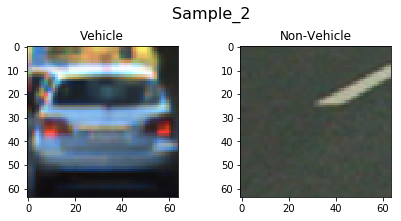

In [4]:
# show 3 random samples of vehicles and non-vehicles

for i in range (3):
    vehicle_num = randint(0, len(vehiclesFN)-1)
    non_vehicle_num = randint(0, len(non_vehiclesFFN)-1)

    test_vehicle_name = vehiclesFN[vehicle_num]
    test_vehicle_FN = vehiclesFFN[vehicle_num]
    test_non_vehicle = non_vehiclesFN[non_vehicle_num]
    test_non_vehicle_FN = non_vehiclesFFN[non_vehicle_num]

    test_vehicle = readImage(test_vehicle_FN)
    test_non_vehicle = readImage(test_non_vehicle_FN)
    images=[]
    titles=[]
    images.append(test_vehicle)
    images.append(test_non_vehicle)
    titles.append('Vehicle')
    titles.append('Non-Vehicle')
    display_save_images_single_line(images, "./SampleImages/", titles, ("Sample_"+str(i)))

### Load the training data and data exporation - end

## Parameters definition - classes

# Value object to hold all feature extraction parameters.

In [5]:
class HogParameters():
    def __init__(self):
        # HOG parameters
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.vis= False

class FeaturesParameters():
    def __init__(self):
        # consider different channels from differnet colors
        self.combined_channels = [['YCrCb',[0,1,2]]] #,['HLS',[0]]] # [['RGB',[0]], ['YCrCb',[0,2]],['HSV',[0]],['LUV',[0,1]]] # 6 channels! instead of 3'RGB' #'YCrCb' [['YCrCb',[0,1,2]]] #
        self.color_space = 'YCrCb' #[('RGB',0),('YCrCb',1),('HSV',0),('LUV',1),('LUV',1)] #'RGB' #'YCrCb'
        # Bin spatial parameters
        self.spatial_size = (32, 32)
        # Histogram parameters
        self.hist_bins = 32
        # HOG parameters
        self.hog_params=HogParameters()

### Parameters definition - end

## HOG parameters selection - HOG visualization

In [6]:
def get_HOG_image(image, p):
    _, hog_image = hog(image, orientations=p.orient, pixels_per_cell=(p.pix_per_cell,p.pix_per_cell), 
                            cells_per_block=(p.cell_per_block, p.cell_per_block), visualise=True, feature_vector=True)
    return hog_image

def color_convert (image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            print("Error undefined color sapace: ", color_space)
    else: 
        feature_image = np.copy(image)      
    return feature_image

In [7]:
def show_spacial(test_vehicles, spacial_size):
    size = (spacial_size,spacial_size)
    test_features_params.spatial_size = (spacial_size,spacial_size)
    for i, test_vehicle in enumerate (test_vehicles):
        images=[]
        titles=[]
        images.append(test_vehicle)
        titles.append('Original')

        color_space = 'RGB'
        feature_image = color_convert(test_vehicle, color_space)
        color1 = cv2.resize(test_vehicle[:,:,0], size)
        color2 = cv2.resize(test_vehicle[:,:,1], size)
        color3 = cv2.resize(test_vehicle[:,:,2], size)
        reseized = np.hstack((color1,color2,color3))
        featured_num = 3*len(cv2.resize(test_vehicle[:,:,2], size).ravel())
        
        images.append(reseized)
        titles.append("Car num: " + str(i))

        imageTitle = "spacial_size_"+str(spacial_size)+"__Color_" + color_space + "featured_num" + str(featured_num)
        display_save_images_single_line(images, './Images/Sapcial', titles, imageTitle, (14,4))
    return

def show_HOG(test_vehicle, test_features_params, car_num):
    test_hog_param = test_features_params.hog_params

    for color_space in tst_colors:
        images=[]
        titles=[]
        if len(color_space)==3:
            channel1name = 'HOG - ' + color_space[0]
            channel2name = 'HOG - ' + color_space[1]
            channel3name = 'HOG - ' + color_space[2]
        elif len(color_space)==5:
            channel1name = 'HOG - ' + color_space[0]
            channel2name = 'HOG - ' + color_space[1:3]
            channel3name = 'HOG - ' + color_space[3:5]
        else:
            channel1name = 'HOG - ' + 'Channel 1'
            channel2name = 'HOG - ' + 'Channel 2'
            channel3name = 'HOG - ' + 'Channel 3'

        feature_image = color_convert(test_vehicle, color_space)
        images.append(test_vehicle)
        titles.append('Original')

        images.append(feature_image)
        titles.append(color_space)

        ch_1_img = feature_image[:,:,0]
        ch_2_img = feature_image[:,:,1]
        ch_3_img = feature_image[:,:,2]
        all_ch_img = ch_1_img/3 + ch_2_img/3 + ch_3_img/3

#         images.append(get_HOG_image(all_ch_img, test_features_params.hog_params))
#         titles.append(color_space)

        images.append(get_HOG_image(ch_1_img, test_features_params.hog_params))
        titles.append(channel1name)

        images.append(get_HOG_image(ch_2_img, test_features_params.hog_params))
        titles.append(channel2name)

        images.append(get_HOG_image(ch_3_img, test_features_params.hog_params))
        titles.append(channel3name)

        imageTitle = "Car__"+str(car_num)+"__Color_" + color_space
        display_save_images_single_line(images, './Images/HOG', titles, imageTitle, (14,4),  gray=True)
    return
    

In [8]:
# Load parameters with hte defualt values
test_features_params = FeaturesParameters()

In [9]:
# Load the test vehicles
test_vehicles_num = [7, 100, 30, 77, 55]
test_vehicles = []
for veh_num in test_vehicles_num:
    test_vehicles.append(readImage(vehiclesFFN[veh_num]))

/home/carkyo1080-1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


./Images/HOG Car__1__Color_RGB


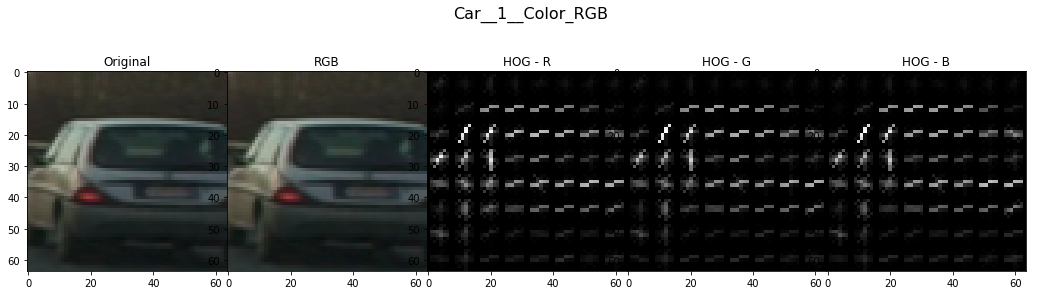

./Images/HOG Car__1__Color_HSV


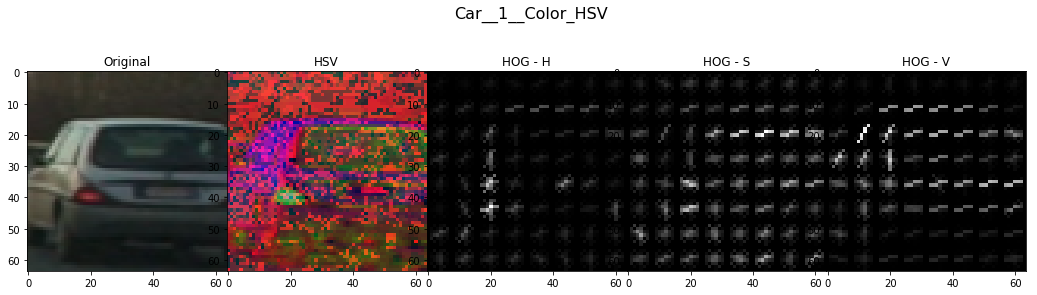

./Images/HOG Car__1__Color_LUV


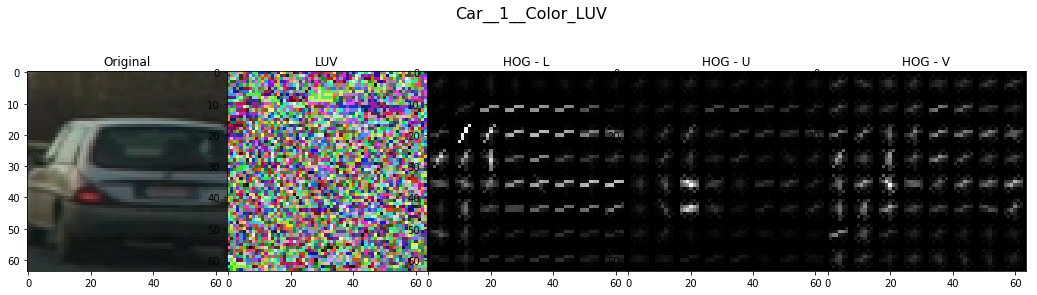

./Images/HOG Car__1__Color_HLS


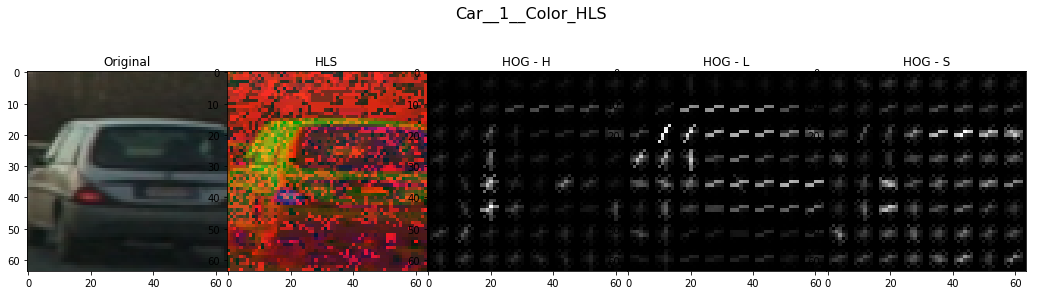

./Images/HOG Car__1__Color_YUV


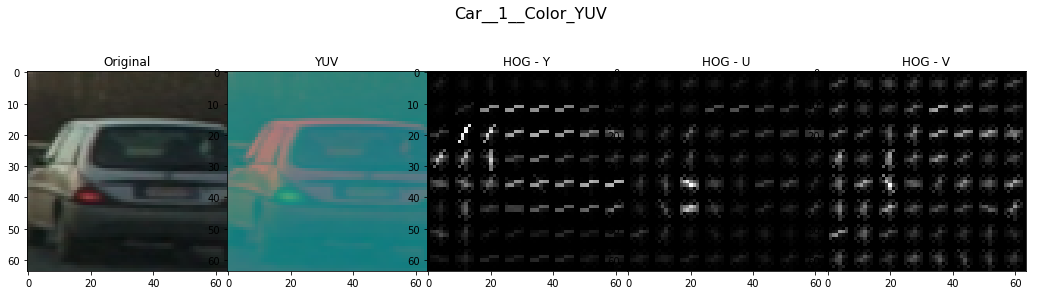

./Images/HOG Car__1__Color_YCrCb


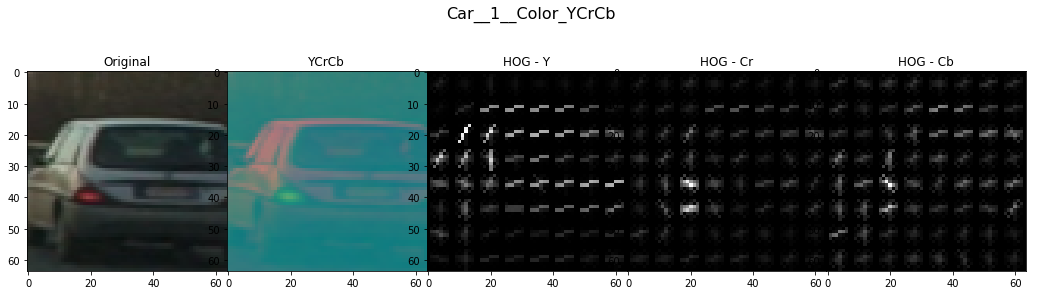

./Images/HOG Car__2__Color_RGB


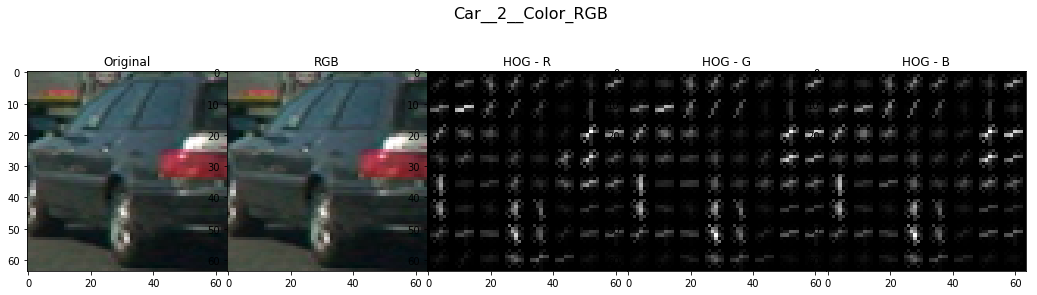

./Images/HOG Car__2__Color_HSV


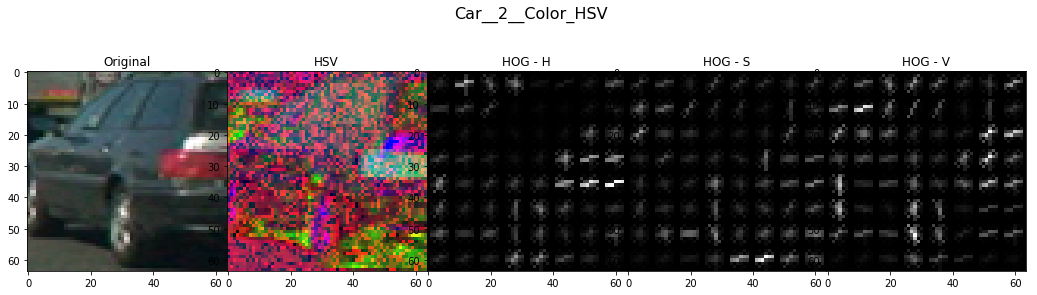

./Images/HOG Car__2__Color_LUV


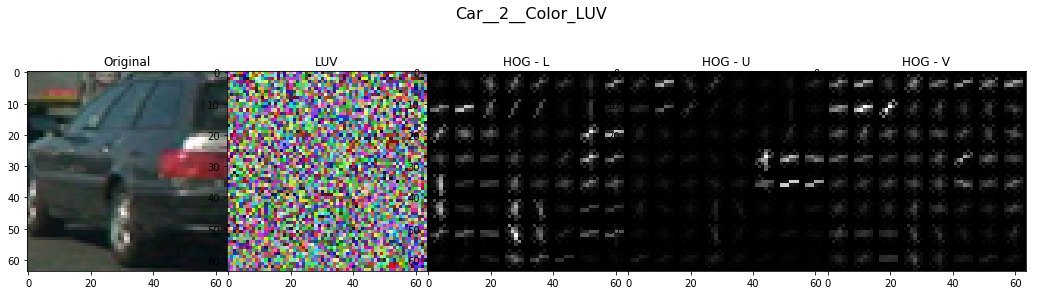

./Images/HOG Car__2__Color_HLS


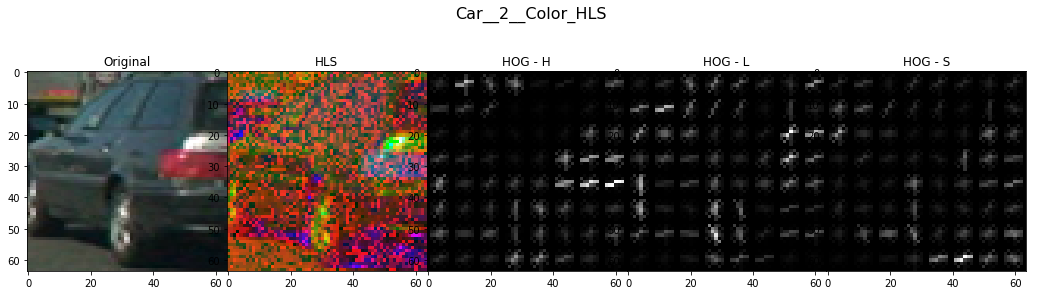

./Images/HOG Car__2__Color_YUV


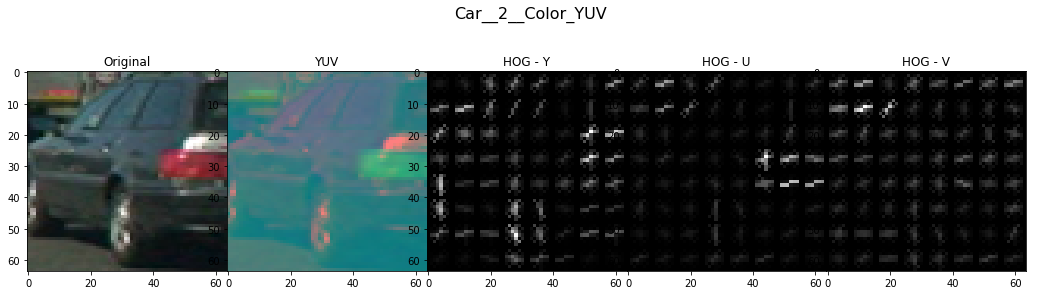

./Images/HOG Car__2__Color_YCrCb


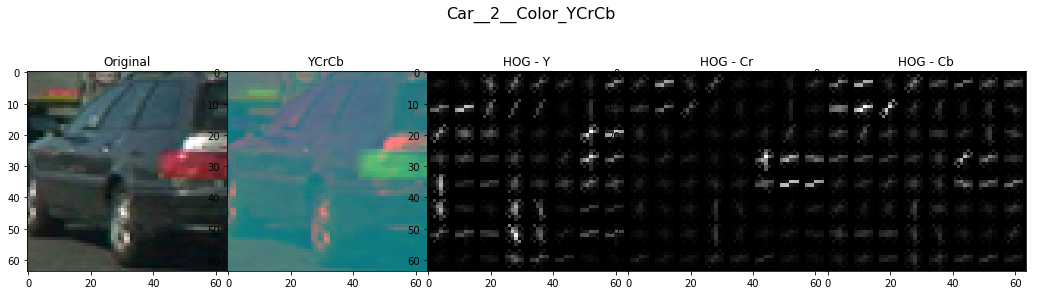

./Images/HOG Car__3__Color_RGB


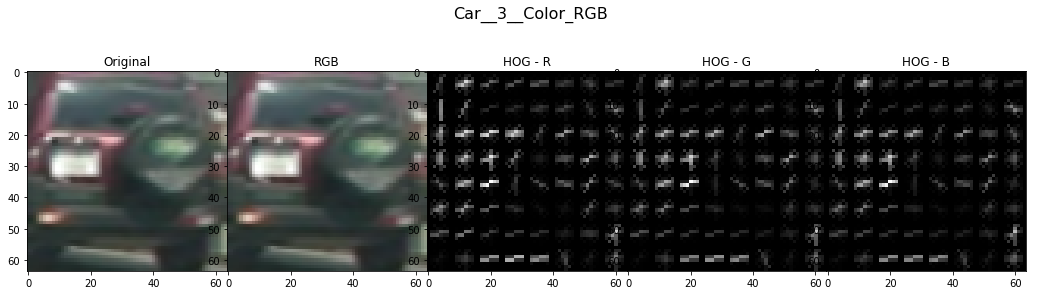

./Images/HOG Car__3__Color_HSV


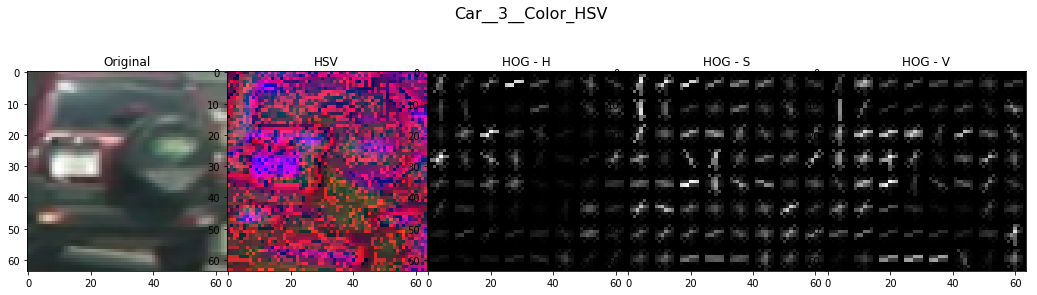

./Images/HOG Car__3__Color_LUV


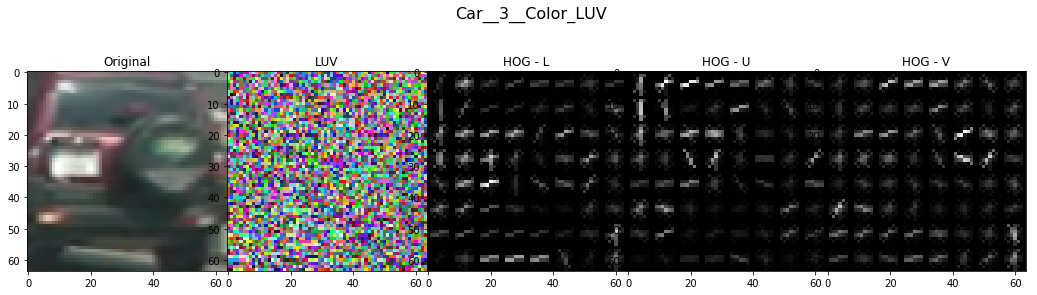

./Images/HOG Car__3__Color_HLS


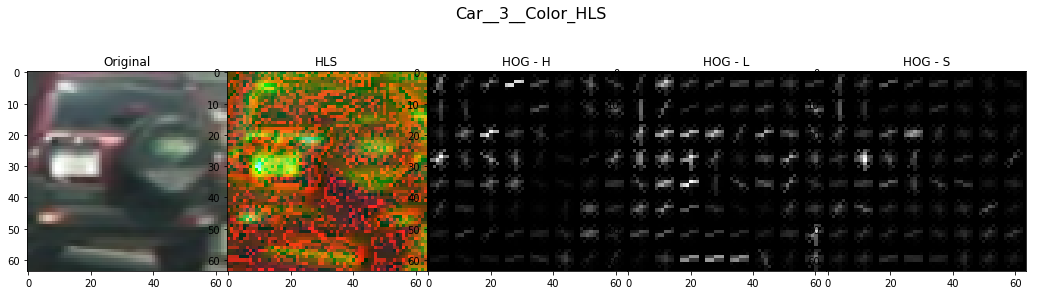

./Images/HOG Car__3__Color_YUV


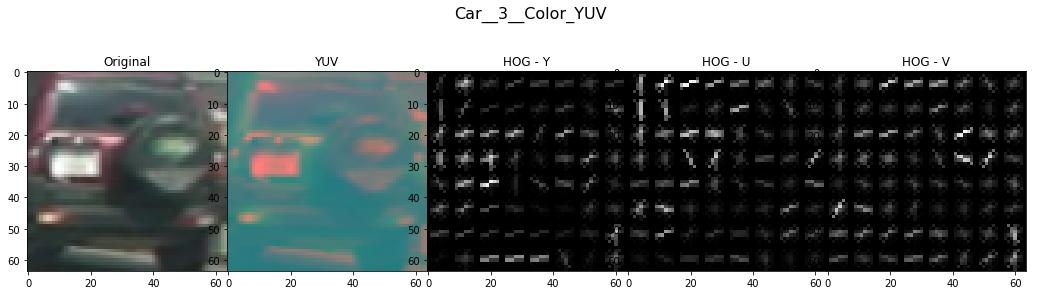

./Images/HOG Car__3__Color_YCrCb


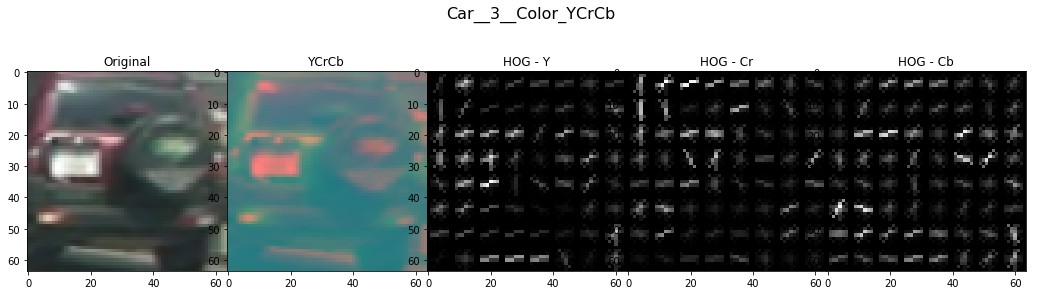

./Images/HOG Car__4__Color_RGB


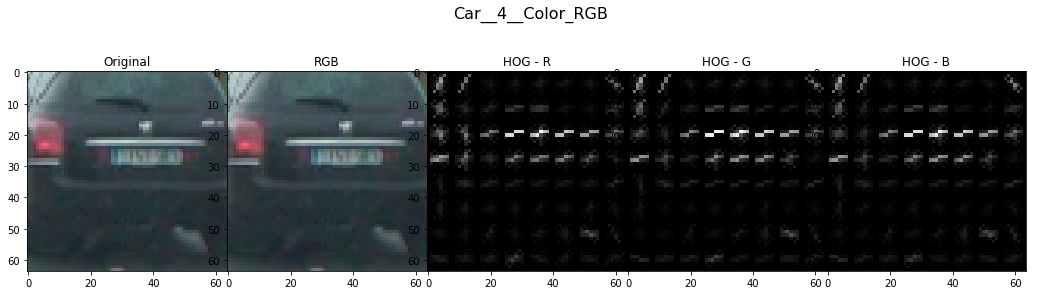

./Images/HOG Car__4__Color_HSV


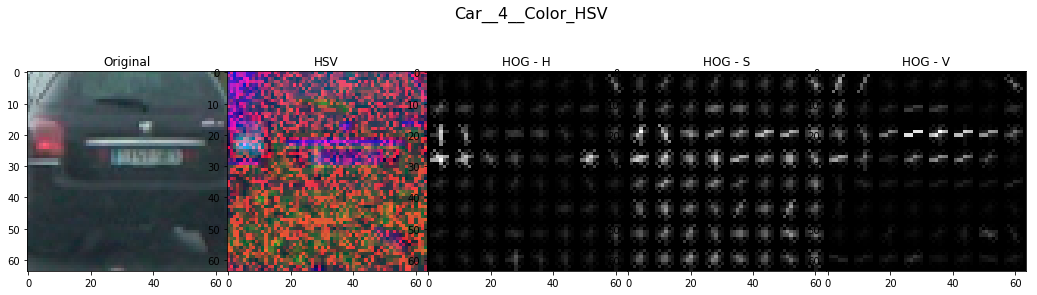

./Images/HOG Car__4__Color_LUV


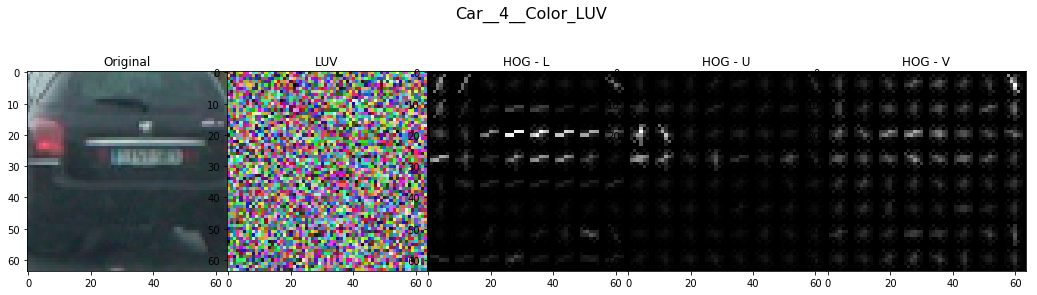

./Images/HOG Car__4__Color_HLS


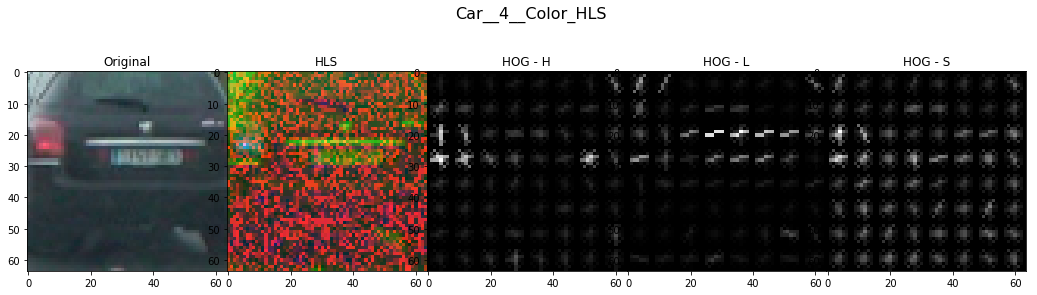

./Images/HOG Car__4__Color_YUV


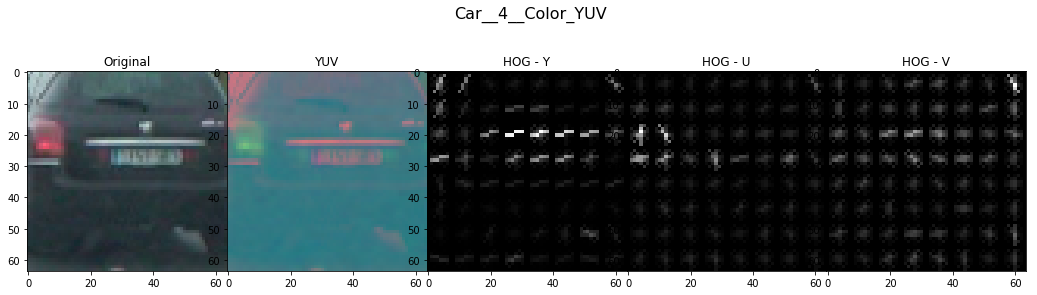

./Images/HOG Car__4__Color_YCrCb


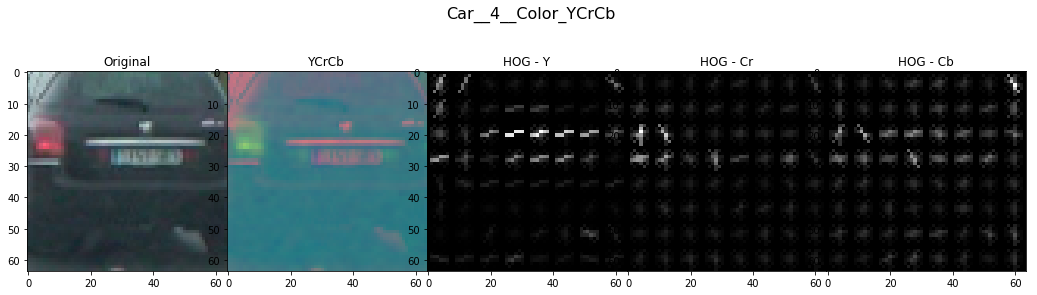

./Images/HOG Car__5__Color_RGB


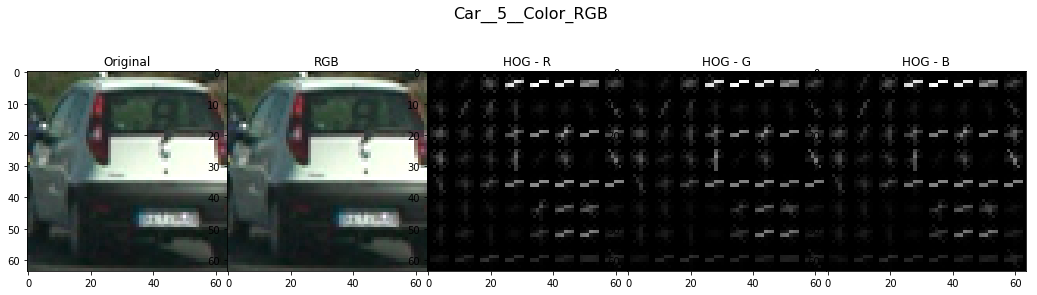

./Images/HOG Car__5__Color_HSV


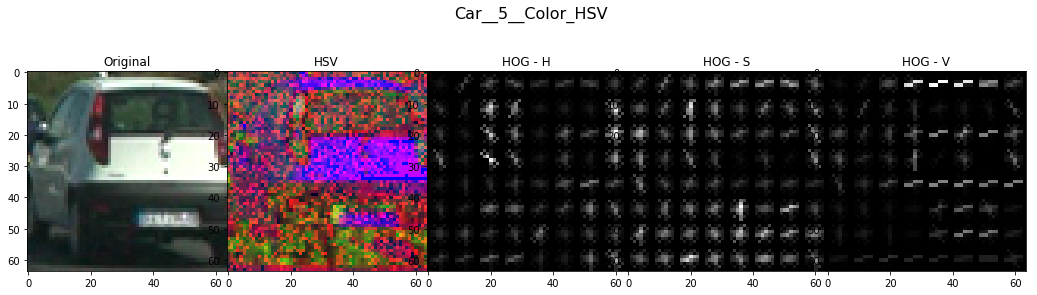

./Images/HOG Car__5__Color_LUV


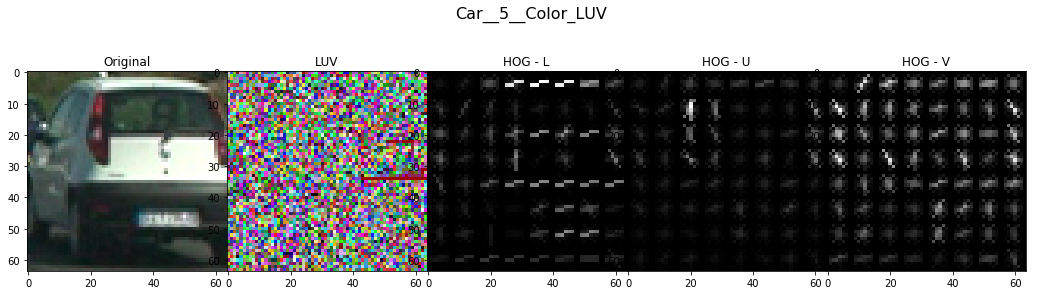

./Images/HOG Car__5__Color_HLS


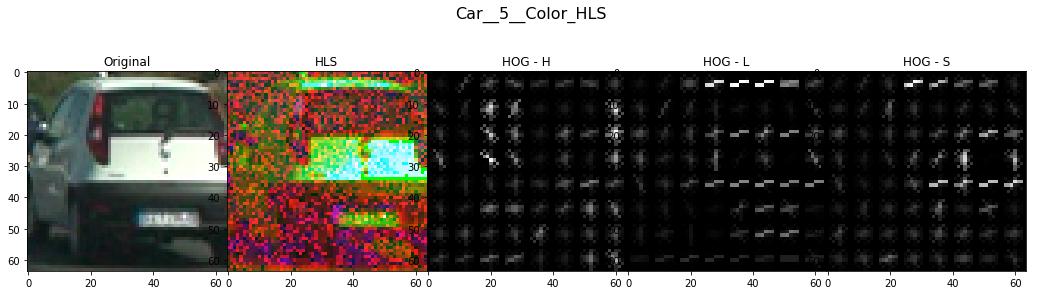

./Images/HOG Car__5__Color_YUV


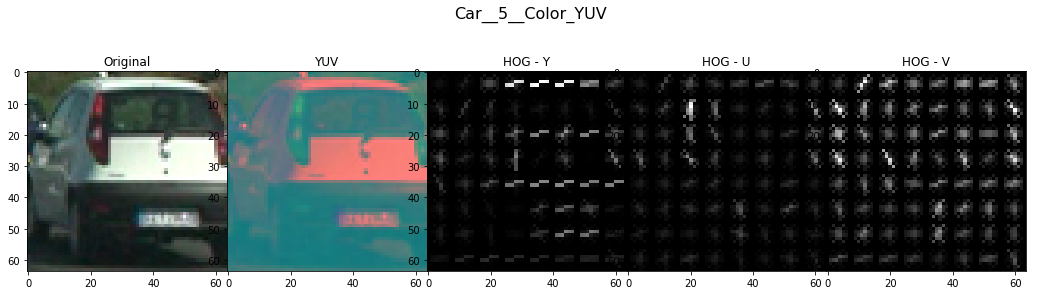

./Images/HOG Car__5__Color_YCrCb


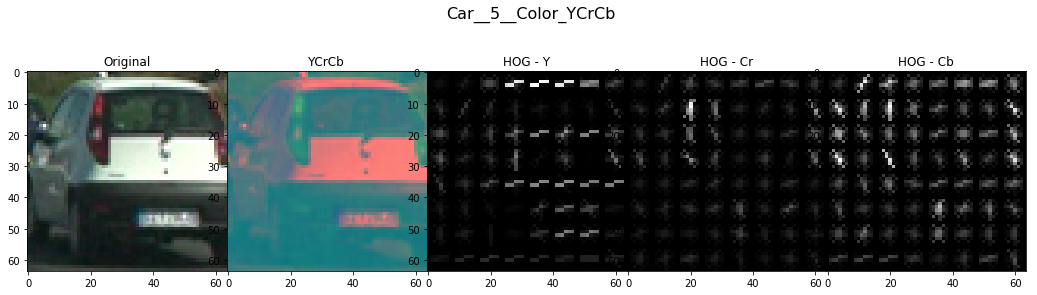

In [10]:
# Test HOG with different color space
tst_colors=['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
for i in range (len(test_vehicles)):
    show_HOG(test_vehicles[i], test_features_params, i+1)

# Conclusion: HOG selection

* Different channels from different color system are meaningfull!
* * Channel of interest: ['R','Y',0],['Cr',1]]#,['H',0],['LUV',0],['LUV',1],['LUV',2]
* * Decision: Try a combination of channels!
* *  The 'feature_image' will be of size different than 3. It could be 5 or 7.
* * * Accordingly modify the:
* * * * color_space paramater = 'RGB' for example to be
* * * * combined_channels = [['RGB',[0]],['YCrCb',[0,2]],['HSV',[0]],['LUV',[0,1]]]
* * * * Chosen chanels for the first iteration: YCr (from YCrCb) and V from (LUV)
* * * * Note 1: The code is not yet fully ready to handle different numbers of Channels than 3 (less for fast response, or more for high precision.
* * * * Note 2: There is a risk of actually getting too many false detection in case of higher number than 3
* * Spacial size (16,16) has been selected

### HOG parameters selection - HOG visualization - end

## Spacial size selection

./Images/Sapcial spacial_size_16__Color_RGBfeatured_num768


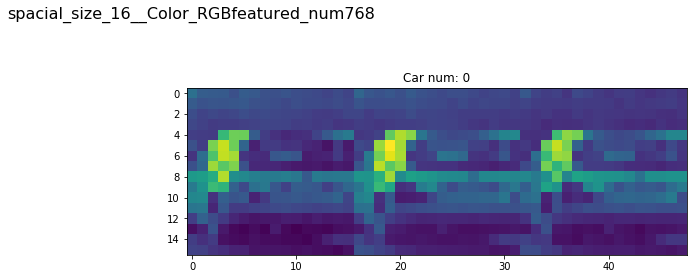

./Images/Sapcial spacial_size_16__Color_RGBfeatured_num768


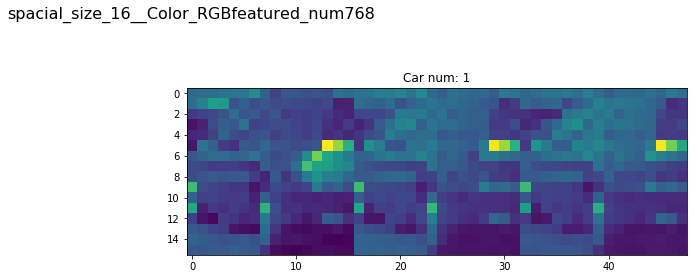

./Images/Sapcial spacial_size_16__Color_RGBfeatured_num768


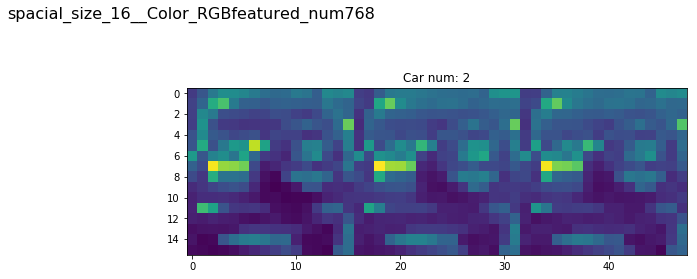

./Images/Sapcial spacial_size_16__Color_RGBfeatured_num768


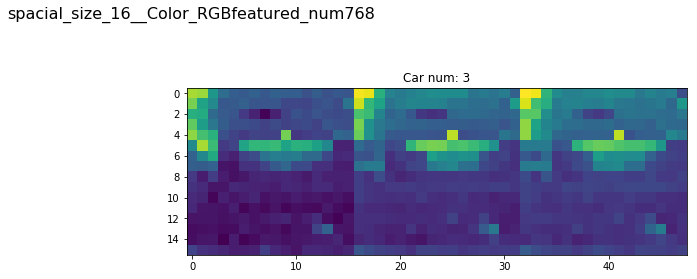

./Images/Sapcial spacial_size_16__Color_RGBfeatured_num768


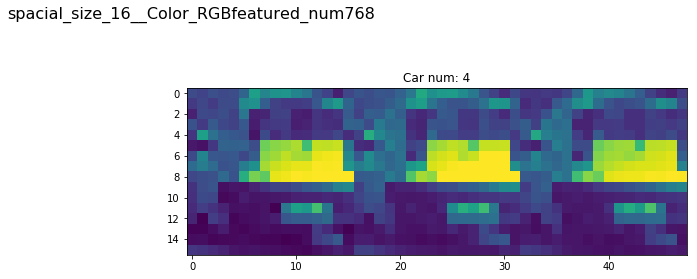

./Images/Sapcial spacial_size_32__Color_RGBfeatured_num3072


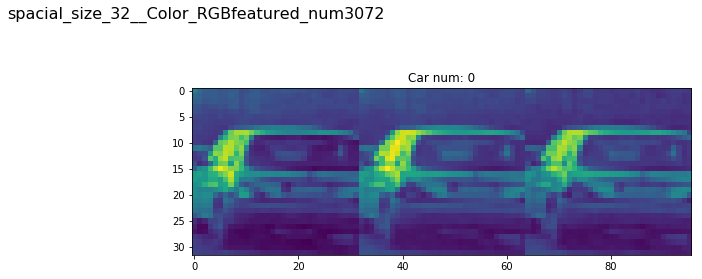

./Images/Sapcial spacial_size_32__Color_RGBfeatured_num3072


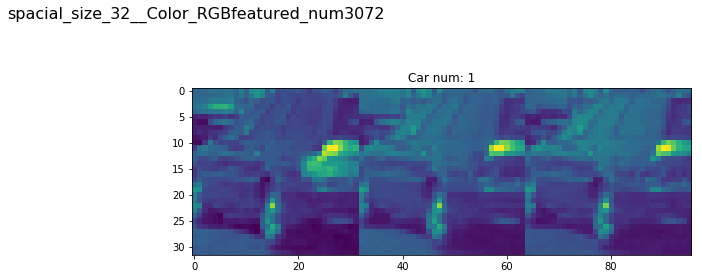

./Images/Sapcial spacial_size_32__Color_RGBfeatured_num3072


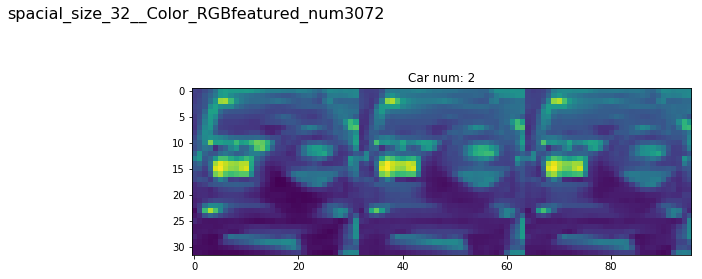

./Images/Sapcial spacial_size_32__Color_RGBfeatured_num3072


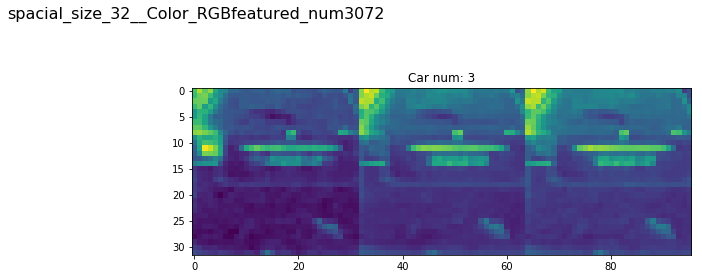

./Images/Sapcial spacial_size_32__Color_RGBfeatured_num3072


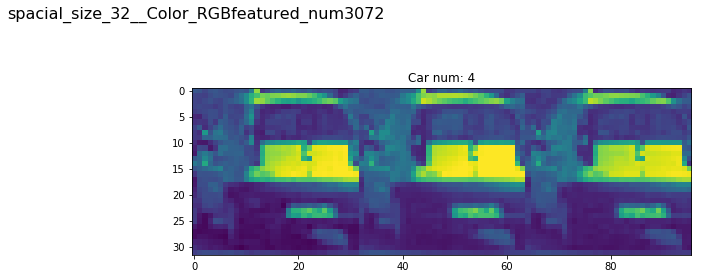

./Images/Sapcial spacial_size_48__Color_RGBfeatured_num6912


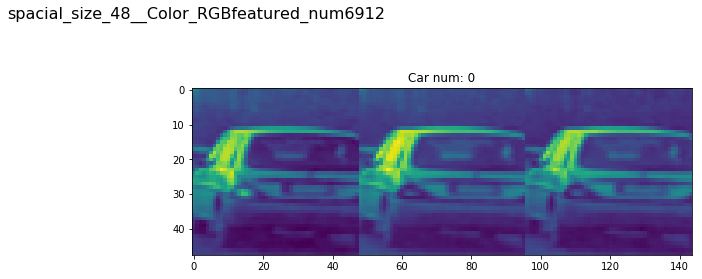

./Images/Sapcial spacial_size_48__Color_RGBfeatured_num6912


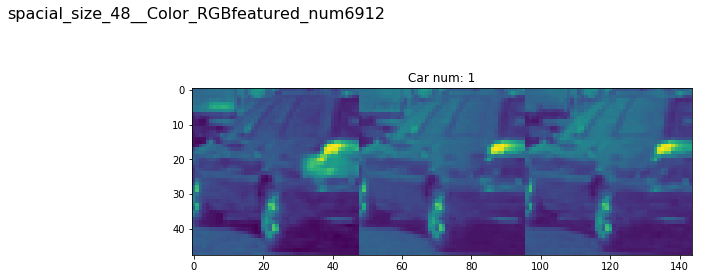

./Images/Sapcial spacial_size_48__Color_RGBfeatured_num6912


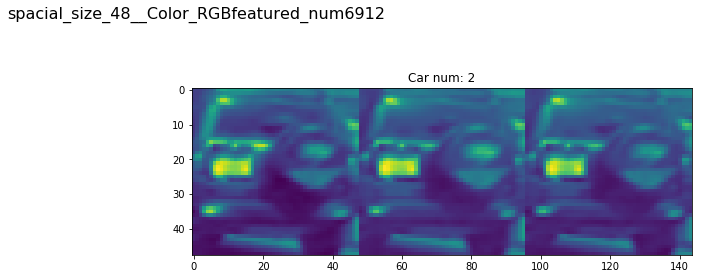

./Images/Sapcial spacial_size_48__Color_RGBfeatured_num6912


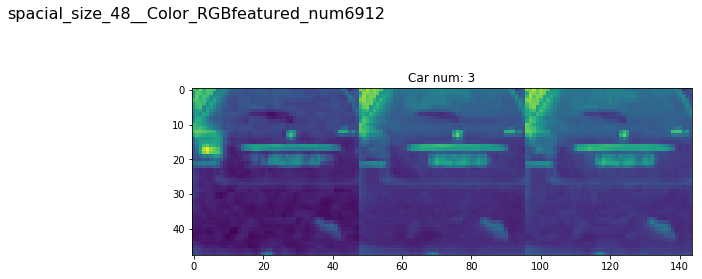

./Images/Sapcial spacial_size_48__Color_RGBfeatured_num6912


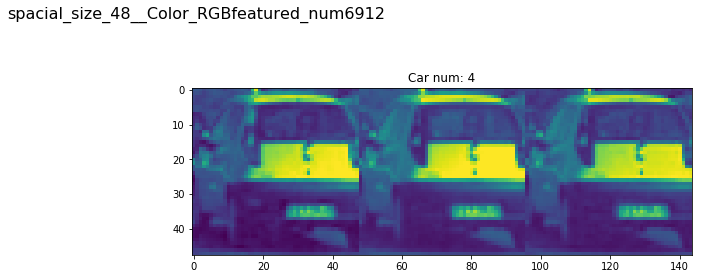

./Images/Sapcial spacial_size_64__Color_RGBfeatured_num12288


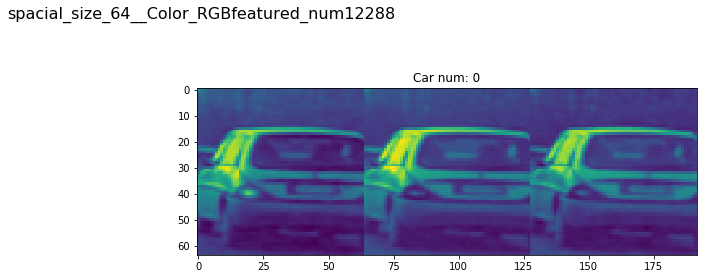

./Images/Sapcial spacial_size_64__Color_RGBfeatured_num12288


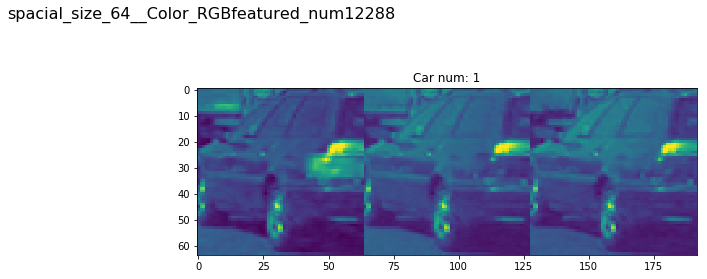

./Images/Sapcial spacial_size_64__Color_RGBfeatured_num12288


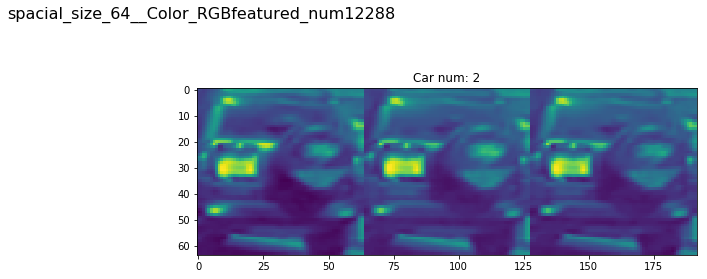

./Images/Sapcial spacial_size_64__Color_RGBfeatured_num12288


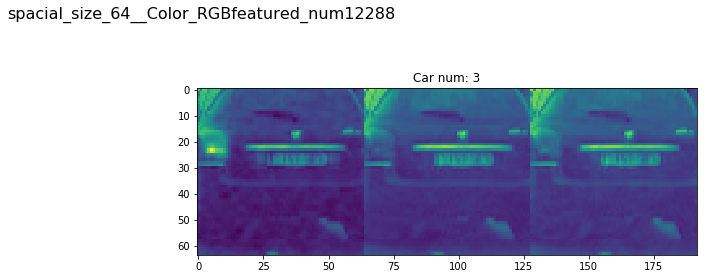

./Images/Sapcial spacial_size_64__Color_RGBfeatured_num12288


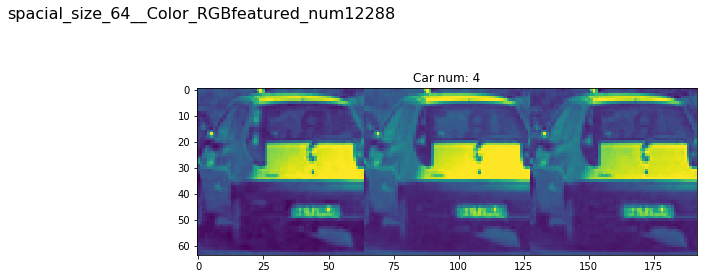

In [11]:
# Test the Spacial size
test_features_params = FeaturesParameters()
for spacial_size in range (16,65,16):
     show_spacial(test_vehicles, spacial_size)